# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# import libraries

import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors # for kNN
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display

# import sys and insert code to ignore warnings 
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

__Load data and conduct a basic check that it's free from obvious issues.__

In [3]:
# load the data 
try:
    df = pd.read_csv('/Users/rraven/Desktop/a_final_yandex/datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.head(2)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14


In [6]:
df.tail(2)

,datetime,num_orders
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [9]:
df.shape

(26496, 2)

__Observations__
- Data is collected in 10 minute intervals between 2018-03-01 00:00:00 and 2018-08-31 23:50:00
- There are 26596 instances and 2 columns, datetime and num_orders
- No missing values or duplicate rows
- Given that datetime datatype is an object --> we need to change it 

__Convert datetime datatype to datetime64__

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

__Set the table index equal to the datetime column__

In [11]:
df = df.set_index(['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


__Sort data and then check if the dates and times are in chronological order__

In [12]:
df.index.is_monotonic

True

__Observations__

- Index is set to datetime
- Data is in chronological order 

__Resample the data by 1 hour__

In [13]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

__Explore the data for patterns__

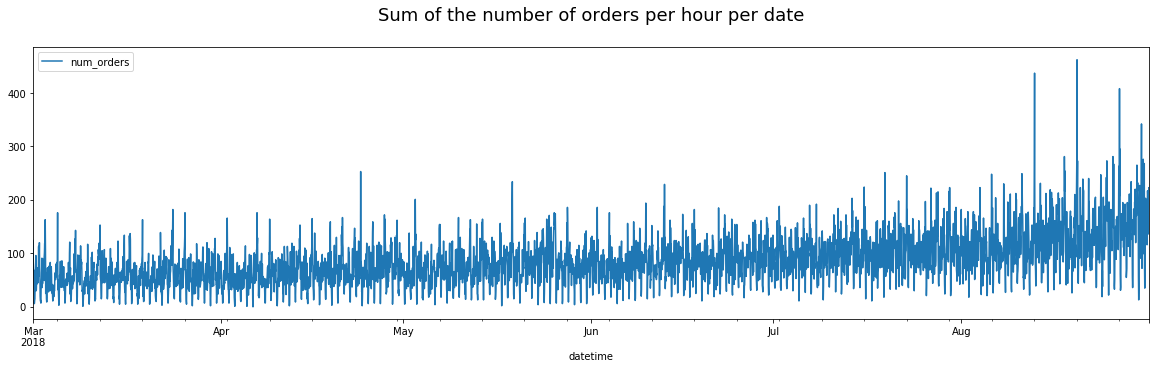

In [14]:
df.plot(figsize=(20,5))
plt.title('Sum of the number of orders per hour per date\n', fontsize=18)
plt.show()

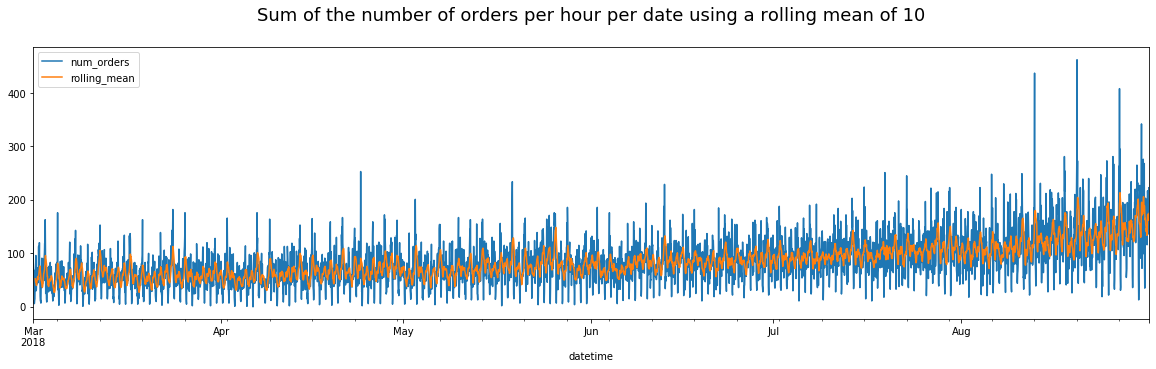

In [15]:
df_roll_10 = df.copy()
df_roll_10['rolling_mean'] = df_roll_10.rolling(10).mean()
df_roll_10.plot(figsize=(20,5))
plt.title('Sum of the number of orders per hour per date using a rolling mean of 10\n', fontsize=18)
plt.show()

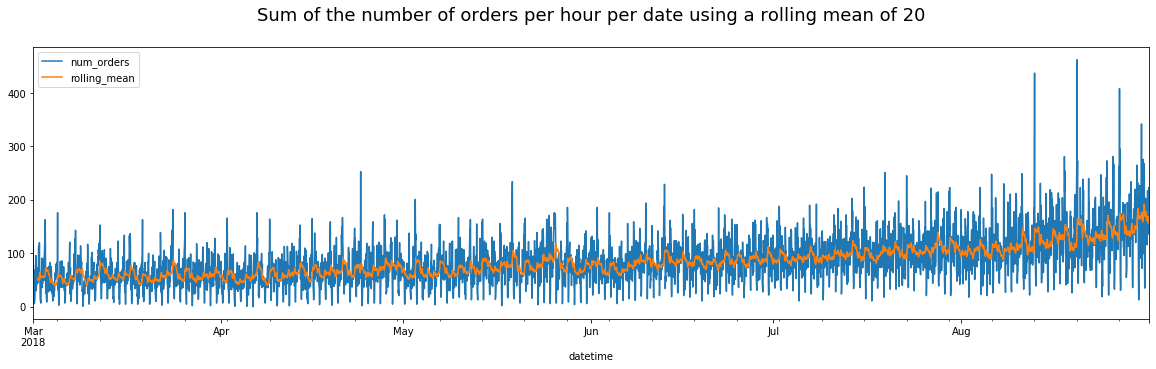

In [16]:
df_roll_20 = df.copy()
df_roll_20['rolling_mean'] = df_roll_20.rolling(20).mean()
df_roll_20.plot(figsize=(20,5))
plt.title('Sum of the number of orders per hour per date using a rolling mean of 20\n', fontsize=18)
plt.show()

__Observations__
- We note fluctions across the 6 month time span, but are not able to demonstrate patterns, seasonality, or trends
- As we increase the rolling mean from 10 to 20 we do note a stronger smoothing of the curve and the overall increase in July and August
- Due to the granularity of hourly data for 6 months of data, we need additional tools to investigate trends, seasonality, and residuals

__Use seasonal_decompose to better understand the time series__

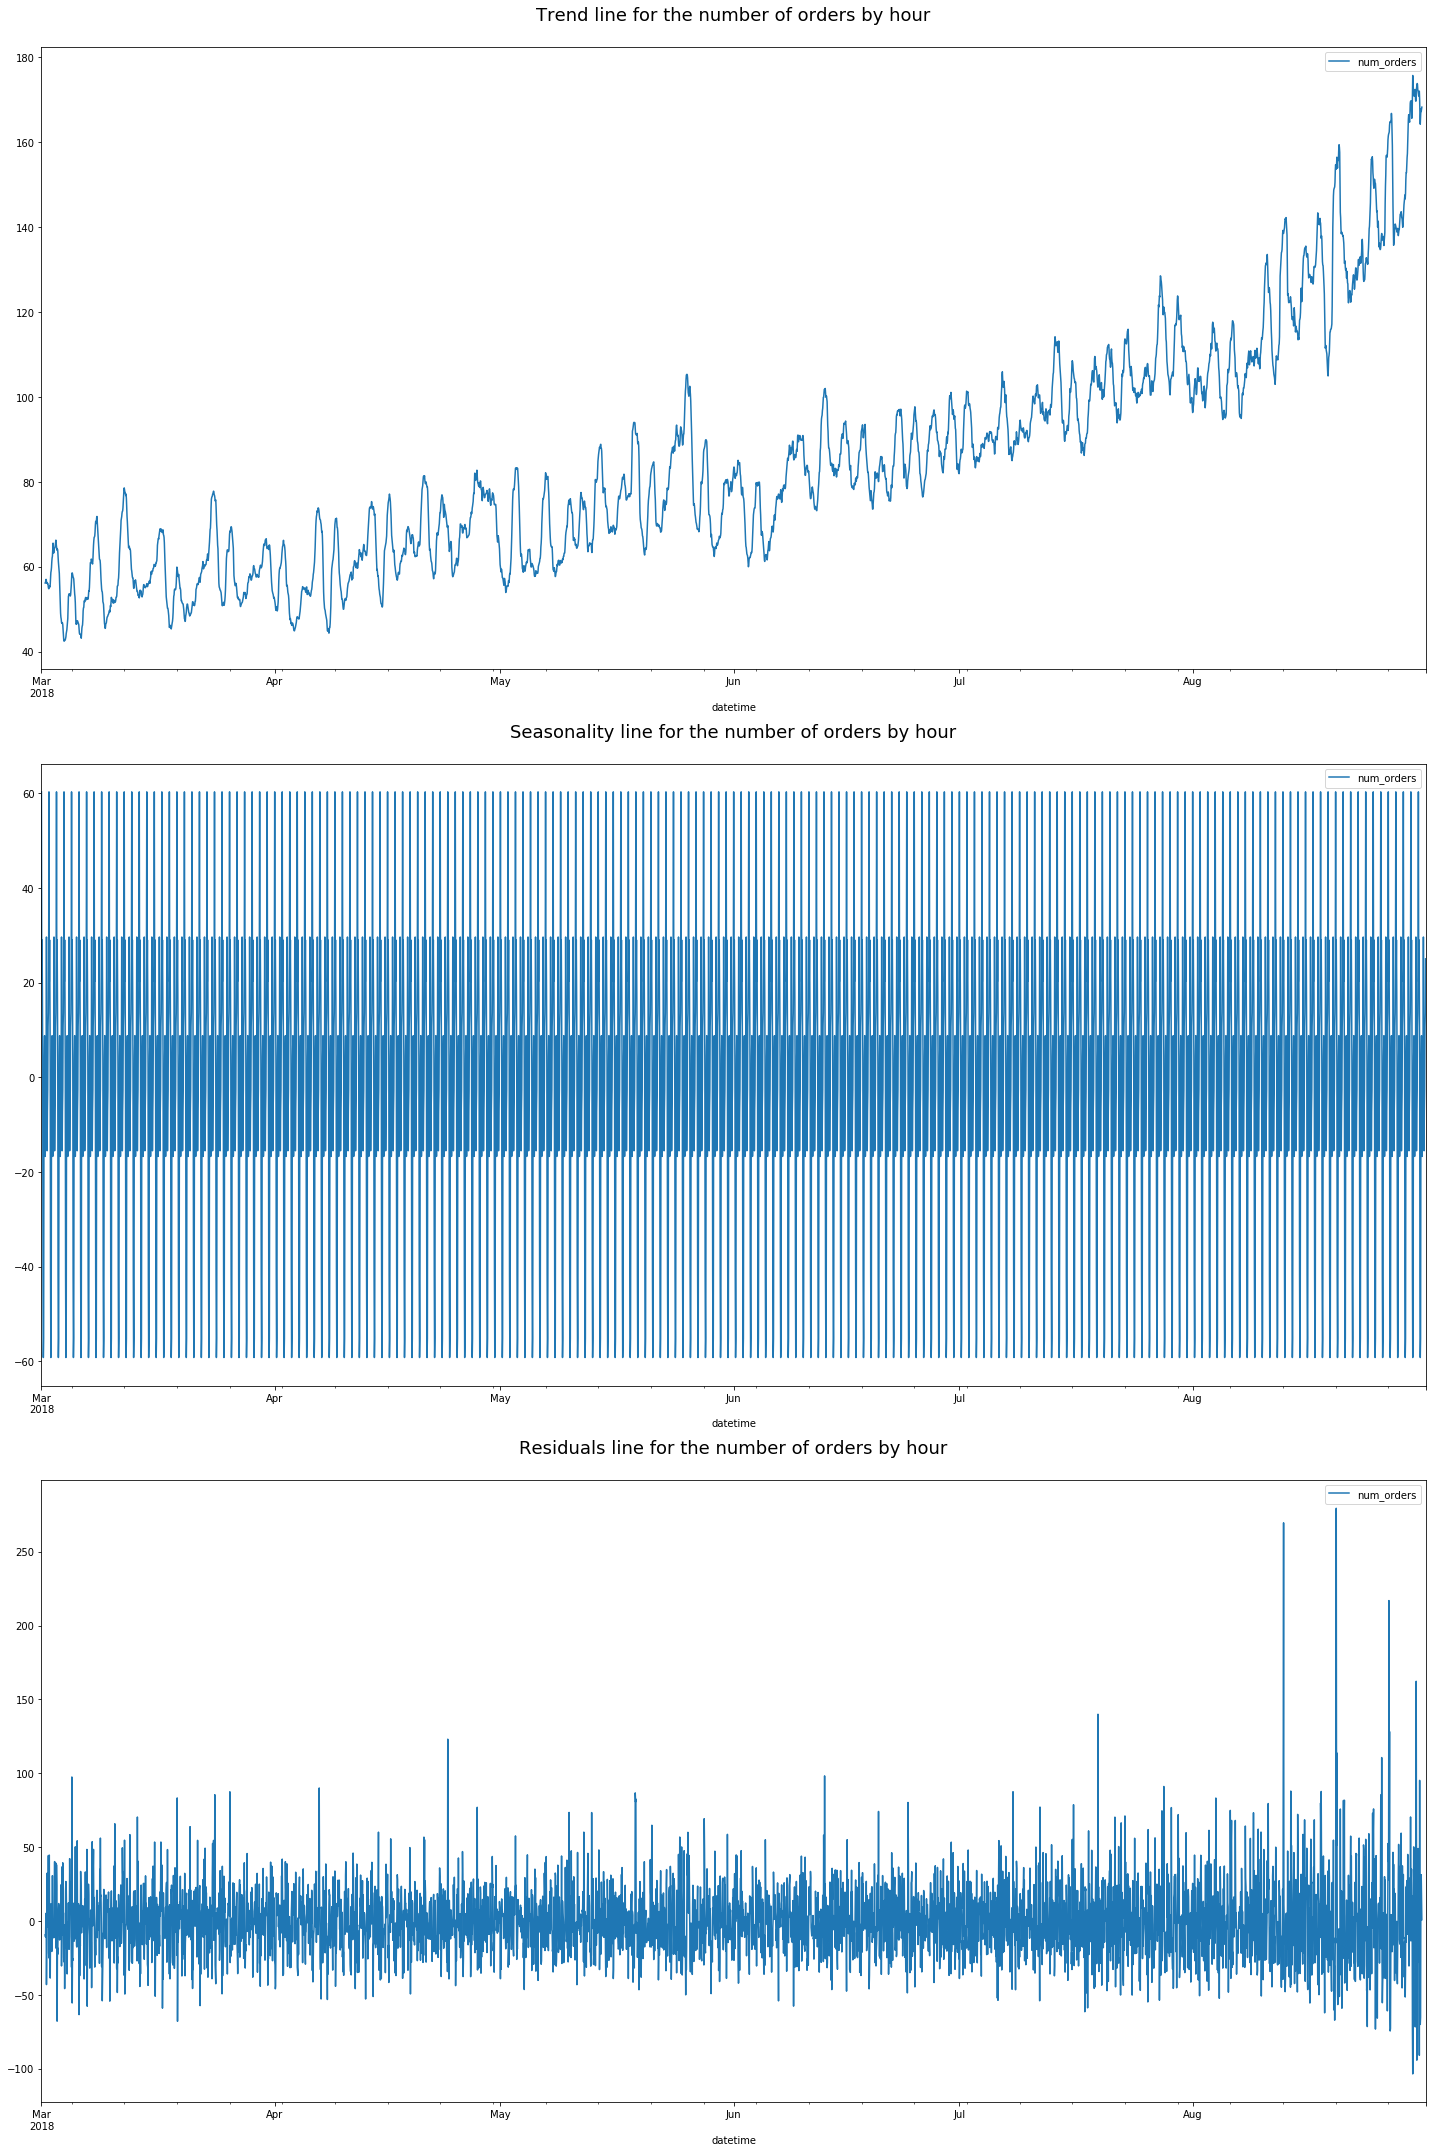

In [17]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(20, 30))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend line for the number of orders by hour\n', fontsize=18)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality line for the number of orders by hour\n', fontsize=18)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals line for the number of orders by hour\n', fontsize=18)
plt.tight_layout();

__Observations__
- As we suspected from the rolling mean charts, the overall trend demonstrates the number of orders per hour is increasing as the months progress
- While we are limited to looking at only 6 months of data, we will not be able to consider monthly or yearly seasonality 
- The regularity of the seasonality graph does suggest there is a pattern --> look for any seasonality in subsections of the df
- The Residuals mostly stay close to zero suggesting a proper decomposition. There is some variability, but it is likely noise

__Decompose the first and last weeks to look for seasonality__

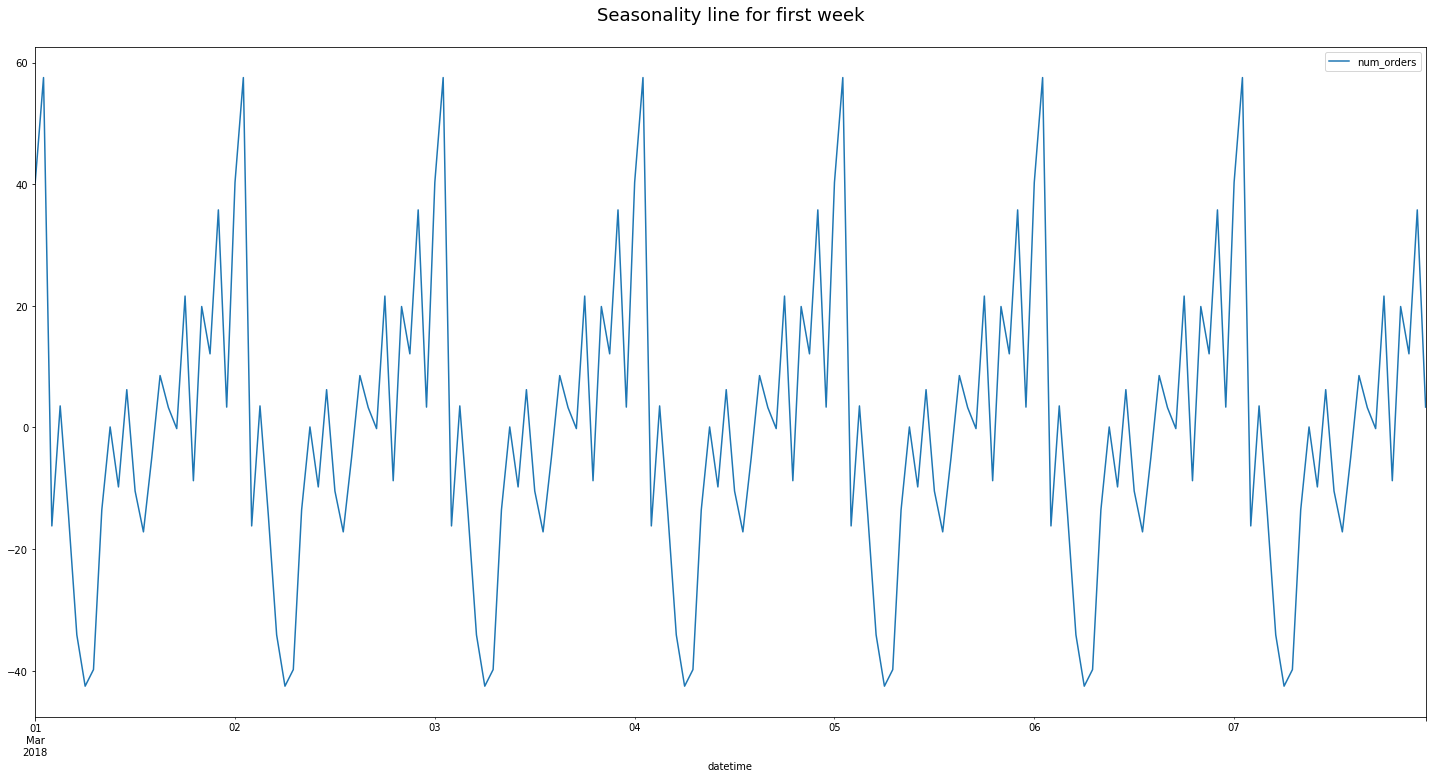

In [18]:
df_firstwk = df['2018-03-01':'2018-03-07']

decomposed = seasonal_decompose(df_firstwk)

plt.figure(figsize=(20, 30))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality line for first week\n', fontsize=18)

plt.tight_layout();



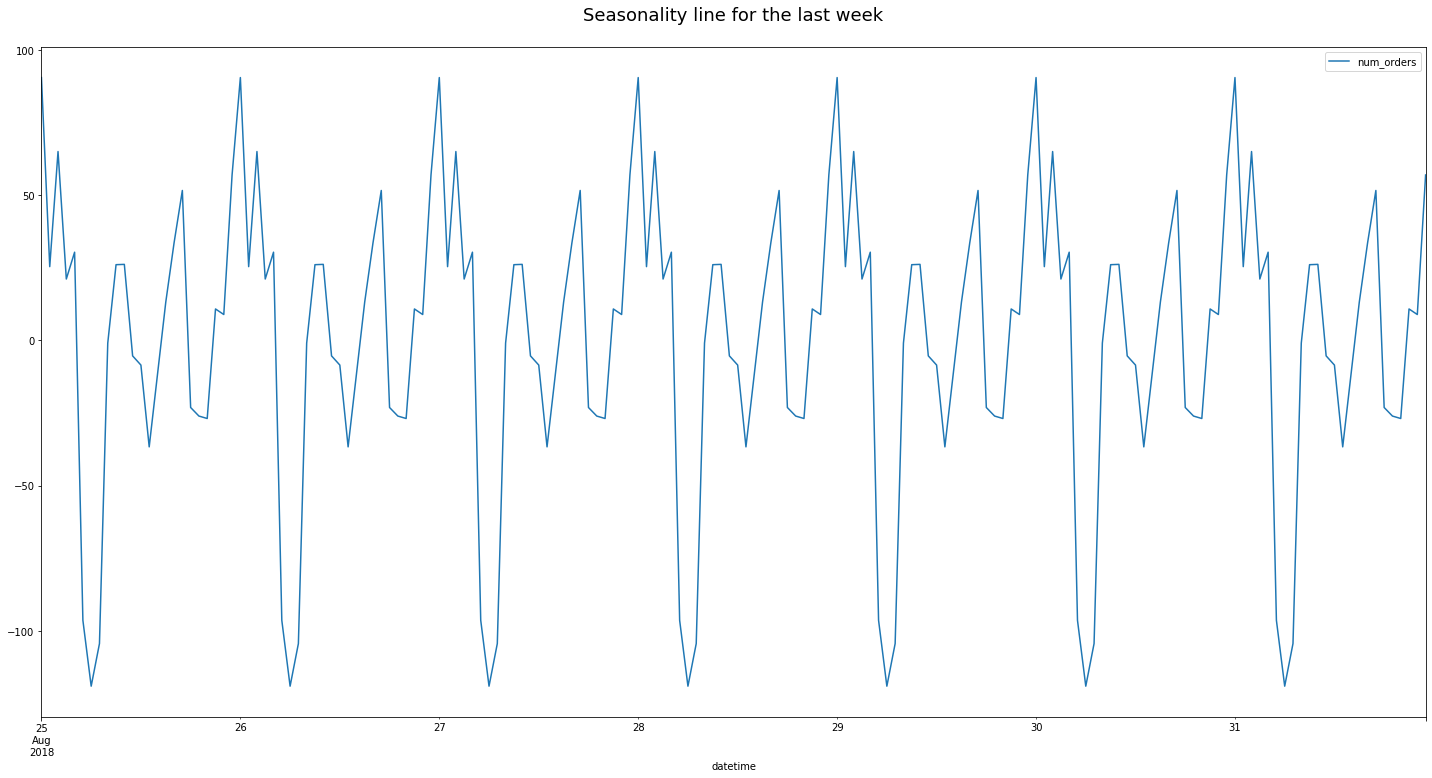

In [19]:
df_lastwk = df['2018-08-25':'2018-08-31']

decomposed = seasonal_decompose(df_lastwk)

plt.figure(figsize=(20, 30))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality line for the last week\n', fontsize=18)

plt.tight_layout();

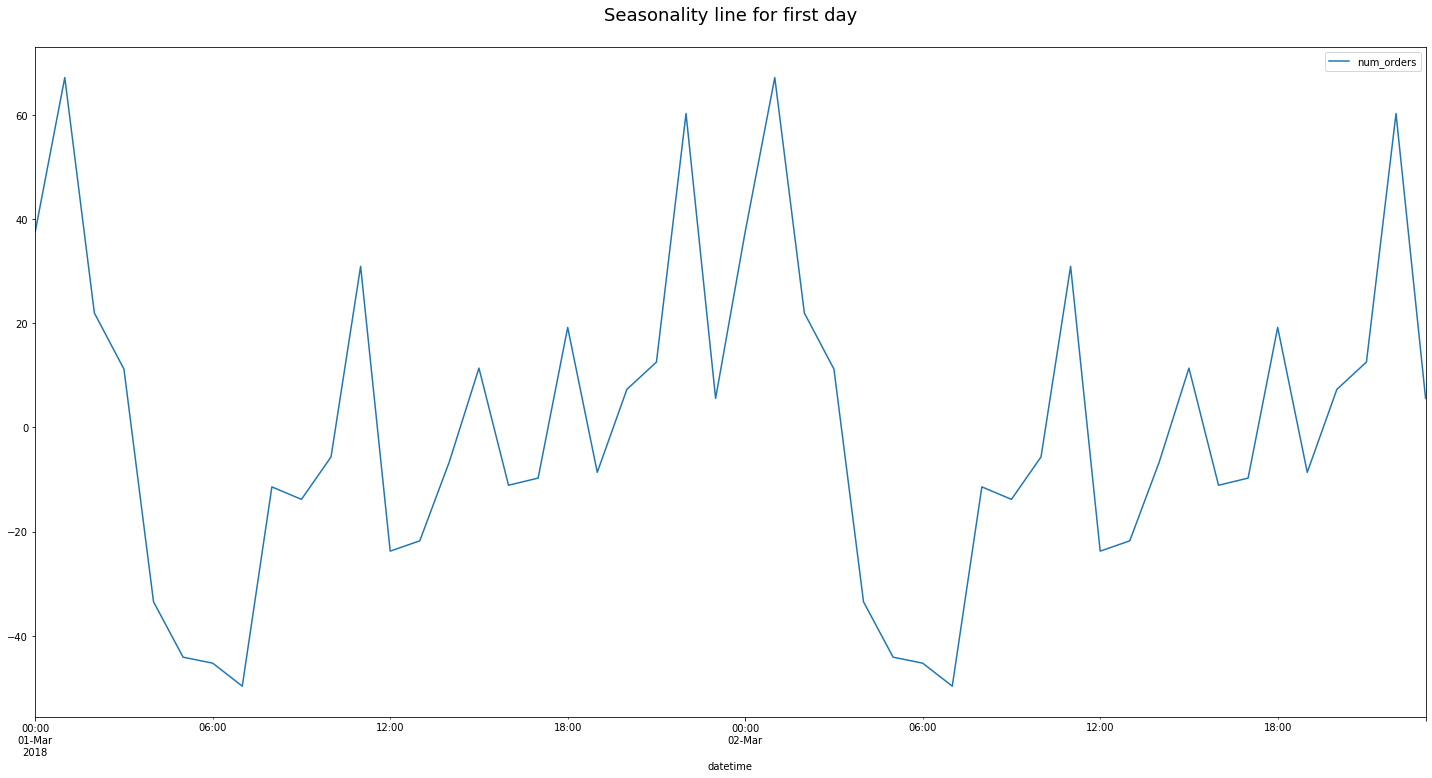

In [20]:
df_firstday = df['2018-03-01':'2018-03-02']

decomposed = seasonal_decompose(df_firstday)

plt.figure(figsize=(20, 30))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality line for first day\n', fontsize=18)

plt.tight_layout();


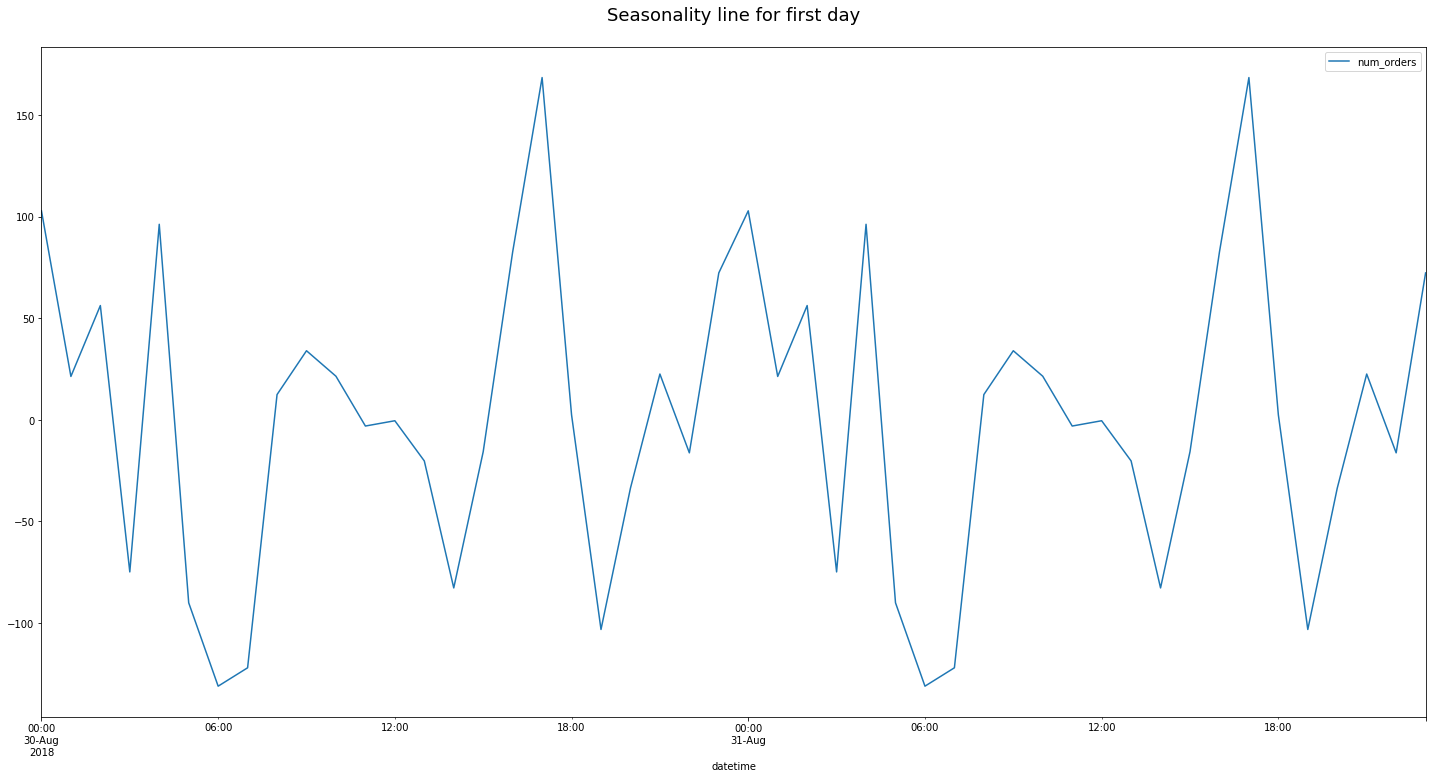

In [21]:
df_lastday = df['2018-08-30':'2018-08-31']

decomposed = seasonal_decompose(df_lastday)

plt.figure(figsize=(20, 30))

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality line for first day\n', fontsize=18)

plt.tight_layout();

__Observations__
- We observe a definite cyclic pattern for days in the first and last week, and we can extrapolate from the pattern of the 6 month Seasonality graph that this same pattern follows through the time period
- The lowest demand occurs at 6 am and 7 pm. Demand fluctuates throughout the 24 hour cycle, but has peaks around midnight and 5 pm.

__Prepare new features from data for better predictions and begin model training__

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Great, you visualized the data, did a seasonal decomposition and noted some patterns. One suggestion: it's better to look at a slice of the decomposed data on the whole dataset, rather than to look at a decomposed slice of the data. That way we are looking at long term patterns

</div>

## Training

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hourofday'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
make_features(df, 10, 5)

df.head()

,num_orders,month,day,dayofweek,hourofday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Split the data using num_orders as the target__

In [23]:
df = df.dropna(how='any', axis=0)

X = df.drop('num_orders', axis=1)
y = df['num_orders']

# note instructions demand 10% of dataset reserved for test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape y_train:', y_train.shape)
print('Shape y_test:', y_test.shape)

print('First train set value:', X_train.index.min())
print('Last train set value:', X_train.index.max())
print('First test set value:', X_test.index.min())
print('Last test set value:', X_test.index.max())


Shape X_train: (3965, 16)
Shape X_test: (441, 16)
Shape y_train: (3965,)
Shape y_test: (441,)
First train set value: 2018-03-01 10:00:00
Last train set value: 2018-08-13 14:00:00
First test set value: 2018-08-13 15:00:00
Last test set value: 2018-08-31 23:00:00


__Observations__
- The dataset has been split correctly, reserved the specified 10% for test data set  
- The training dataset has 3965 instances 
- The test dataset consists of 441 instances 
- Since this is a time series forecast, the dataset cannot be shuffled and the training data must precede the testing data, which we\'ve verified
- The training data runs from 3/1/18 to 8/13/18 while the test data runs from 8/13/18 to 8/31/18

__Scale data and select models for regression analysis using RMSE to select the best model__

In [24]:
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
tscv = TimeSeriesSplit() # to be used to split into train and validation

In [26]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_scorer = make_scorer(rmse, greater_is_better = False)

__Observations__ 
- We scaled the data
- We inststiated the TimeSeriesSplit to divide the training ds into train and validation segments
- We created the rmse_scorer so we can compare our models

__Create baseline model and random forest regressor model__

In [27]:
model = DummyRegressor(strategy='median')
baseline = np.mean(abs(cross_val_score(model,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
baseline

43.97614810149032

In [28]:
rf = RandomForestRegressor(random_state=12345)
rf_original = np.mean(abs(cross_val_score(rf,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
rf_original

27.919617049851286

In [29]:
%%time
params = {"n_estimators" : [500, 700],
             "max_depth" : [6, 7, 8, 9, 10]}

gsSVR = GridSearchCV(estimator=rf, cv=tscv, param_grid=params, n_jobs=-1, verbose=0, scoring=rmse_scorer)
gsSVR.fit(X_train, y_train)
SVR_best = gsSVR.best_estimator_
print(abs(gsSVR.best_score_))

27.435643252441903
CPU times: user 2min 37s, sys: 317 ms, total: 2min 37s
Wall time: 2min 38s


In [30]:
%%time
best_param = pd.DataFrame(gsSVR.best_params_, index=[0])
rf_tuned = abs(gsSVR.best_score_)
best_param['score'] = rf_tuned

best_param

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 1.76 ms


,max_depth,n_estimators,score
0,10,500,27.435643


__Observations__
- The RMSE for the dummy regressor model is over 40, but we anticipate a higher RMSE in when we run the test data set because of the increased variablility and volume for August
- Even without hyperparameter tuning, our random forest regressor model performs markedly better by the RMSE metric
- The best parameters of 10 max_depth and 500 n_estimators slightly improves/lowers the RMSE score

__Create LightGBM model__

In [31]:
%%time
lgbm = LGBMRegressor(random_state=12345)
lgbm_original = np.mean(abs(cross_val_score(lgbm,  X_train, y_train, cv=tscv, scoring = rmse_scorer)))
lgbm_original

CPU times: user 3.12 s, sys: 27 ms, total: 3.15 s
Wall time: 3.1 s


26.86632789859263

In [34]:
%%time
params = {"n_estimators" : [500, 700],
             "max_depth" : [6, 7, 8, 9, 10]}

gsSVR = GridSearchCV(estimator=lgbm, cv=tscv, param_grid=params, n_jobs=-1, verbose=0, scoring=rmse_scorer)
gsSVR.fit(X_train, y_train)
SVR_best = gsSVR.best_estimator_
print(abs(gsSVR.best_score_))

26.93408739427501
CPU times: user 2min 13s, sys: 1.39 s, total: 2min 14s
Wall time: 2min 15s


In [35]:
%%time
best_param = pd.DataFrame(gsSVR.best_params_, index=[0])
lgbm_tuned = abs(gsSVR.best_score_)
best_param['score'] = lgbm_tuned

best_param

CPU times: user 1.91 ms, sys: 16 µs, total: 1.92 ms
Wall time: 1.69 ms


,max_depth,n_estimators,score
0,9,500,26.934087


__Conclusions__
- The LightGBM model demonstrates a slightly better RMSE score than the forest regressor
- The best parameters of 9 max_depth and 500 n_estimators actually made the RMSE score slightly worse

__Test the test data set using using the tuned Random Forest Regressor model and the LightGBM model__

## Testing

In [36]:
%%time
rf.fit(X_train, y_train)
test_pred = rf.predict(X_test)
rf_test_score = rmse(y_test, test_pred)
rf_test_score

CPU times: user 279 ms, sys: 226 µs, total: 279 ms
Wall time: 289 ms


48.74518965743419

In [37]:
%%time
lgbm.fit(X_train, y_train)
test_pred = lgbm.predict(X_test)
lgbm_test_score = rmse(y_test, test_pred)
lgbm_test_score

CPU times: user 1.21 s, sys: 9.57 ms, total: 1.22 s
Wall time: 1.2 s


42.82142828865436

__Conclusions__

- We downloaded, examined, resampled the data by one hour, and split the data for model training
- We trained 2 different models and tuned hyperpramaters, reserving 10% of the initial dataset for testing
- We discovered the random forest regression model RMSE improved with hyperparameter tuning
- However, tuning didn't appear to improve the LightGBM model's RMSE metric
- We observed the random forest regression model produced an RMSE metric slightly above the desired threshold of 48 on the test data
- Luckily, the lightGBM model produced RMSE scores less than 48 on the test data

__We recommend using the LightGBM model to predict the amount of taxi orders for the next hour based on goodness of fit as measured by RMSE__